In [1]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker, declarative_base
from easynmt import EasyNMT
from transformers import BertModel, BertTokenizer
import torch
import umap
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors, RadiusNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
import yake
from copy import deepcopy
from kneed import KneeLocator
import math
import demoji

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DB Connection

In [2]:
engine = create_engine('sqlite:////Users/quimpm/Desktop/twitter_profiling/data/twitter_profiling.db')
Session = sessionmaker(bind=engine)
session = Session()
Base = declarative_base()

In [3]:
from sqlalchemy import Column, Integer, String, Boolean


class Tweet(Base):
    __tablename__ = 'tweet'

    id = Column(Integer, primary_key=True)
    user_id = Column(Integer)
    exec_id = Column(String)
    username = Column(String)
    at = Column(String)
    text = Column(String)
    views = Column(Integer)
    replies = Column(Integer)
    retweets = Column(Integer)
    likes = Column(Integer)
    imgs = Column(String)
    link = Column(String)
    time = Column(String)
    is_retweeted = Column(Boolean)

    def __init__(self, exec_id, user_id, username, at, text, views, replies, retweets, likes, imgs, links, time,  is_retweeted):
        self.exec_id = exec_id
        self.user_id = user_id
        self.username = username
        self.at = at
        self.text = text.replace("\n", " ").replace(",", " ").replace("  ", " ")
        self.views = views
        self.replies = replies
        self.retweets = retweets
        self.likes = likes
        self.imgs = imgs
        self.links = links
        self.time = time
        self.is_retweeted = is_retweeted

    def __hash__(self):
        return hash(f'{self.exec_id}{self.username}{self.at}{self.text}{str(self.views)}{str(self.replies)}{str(self.retweets)}{str(self.likes)}{self.imgs}{self.video}{self.link}{self.time}')


In [4]:
class Document(Base):
    __tablename__ = 'document'

    id = Column(Integer, primary_key=True)
    exec_id = Column(String)
    corpus_id = Column(Integer)
    text = Column(String)

    def __init__(self, exec_id, corpus_id, text):
        self.exec_id = exec_id
        self.corpus_id = corpus_id
        self.text = text

In [5]:
def translate_text(text):
    model = EasyNMT('opus-mt')
    try:
        return model.translate(text, target_lang="en")
    except:
        return text

In [6]:
documents = session.query(Tweet).filter_by(exec_id="2557df56-a1ad-11ed-a922-0242ac140005").all()
documents_text = list(map(lambda x: x.text, documents))
documents_text[:10]

['@Gerashchenko_en Damned if you do damned if you don’t',
 '@JonErlichman True',
 '@TaraBull808 Yeah it’s bizarre!',
 'Another batch of Starlinks in orbit. These will mostly support high latitude connectivity.',
 '@stillgray @Lukewearechange They are behind the times',
 'Hydro nuclear fission &amp; geothermal will also be significant parts of the solution',
 '@Lukewearechange Accurate',
 '@ZaleskiLuke You are an expert in propaganda 😂',
 'Wind &amp; solar combined with batteries will solve sustainable energy for Earth',
 '@Erdayastronaut @flightclubio Expendable upper stage may or may not fly but it is an option']

In [7]:
df = pd.DataFrame(documents_text, columns =['text'])
df

,text
0,@Gerashchenko_en Damned if you do damned if yo...
1,@JonErlichman True
2,@TaraBull808 Yeah it’s bizarre!
3,Another batch of Starlinks in orbit. These wil...
4,@stillgray @Lukewearechange They are behind th...
...,...
995,Twitter will start incorporating mute &amp; bl...
996,The people have spoken. Accounts who doxxed my...
997,@catturd2 Indeed there is no other reason
998,@Lukewearechange Umm … yeah


Get BERT Embedings

In [8]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
def get_embeddinngs(text):
    inputs = tokenizer(text, return_tensors="pt")
    return model(**inputs).pooler_output.tolist()

def flat_map(f, xs):
    ys = []
    for x in xs:
        ys.extend(f(x))
    return ys

In [10]:
df['emb'] = df['text'].apply(get_embeddinngs)
df

,text,emb
0,@Gerashchenko_en Damned if you do damned if yo...,"[[-0.6921208500862122, -0.2536858916282654, 0...."
1,@JonErlichman True,"[[-0.7792775630950928, -0.3437073826789856, 0...."
2,@TaraBull808 Yeah it’s bizarre!,"[[-0.7318082451820374, -0.16536948084831238, 0..."
3,Another batch of Starlinks in orbit. These wil...,"[[-0.7834610342979431, -0.4638417363166809, -0..."
4,@stillgray @Lukewearechange They are behind th...,"[[-0.8011219501495361, -0.28334784507751465, 0..."
...,...,...
995,Twitter will start incorporating mute &amp; bl...,"[[-0.8406918048858643, -0.4140477478504181, -0..."
996,The people have spoken. Accounts who doxxed my...,"[[-0.8792438507080078, -0.46077966690063477, -..."
997,@catturd2 Indeed there is no other reason,"[[-0.5551023483276367, -0.10706595331430435, 0..."
998,@Lukewearechange Umm … yeah,"[[-0.7524970173835754, -0.221048042178154, 0.4..."


Reduce Dimensionality

In [11]:
embeddings = list(map(lambda x: x[0], df['emb']))

In [12]:
embeddings[0]

[-0.6921208500862122,
 -0.2536858916282654,
 0.3137916326522827,
 0.3864419162273407,
 -0.4286388158798218,
 0.007460254710167646,
 0.6762543320655823,
 0.19046036899089813,
 0.2893693149089813,
 -0.9994174242019653,
 0.3182276785373688,
 -0.1520187109708786,
 0.9618068933486938,
 -0.22975574433803558,
 0.805749237537384,
 -0.16071468591690063,
 0.23706020414829254,
 -0.42374128103256226,
 0.3283831477165222,
 -0.39243635535240173,
 0.46850109100341797,
 0.8826006650924683,
 0.6128430366516113,
 0.1359729766845703,
 0.3817059099674225,
 -0.08187083154916763,
 -0.3332150876522064,
 0.8463127613067627,
 0.9037137031555176,
 0.5037223696708679,
 -0.49393194913864136,
 0.20028753578662872,
 -0.9607807993888855,
 -0.17209677398204803,
 0.18960852921009064,
 -0.9688908457756042,
 0.14879758656024933,
 -0.5898998379707336,
 0.036117810755968094,
 -0.05910147354006767,
 -0.7181234955787659,
 0.2046063095331192,
 0.9902971982955933,
 -0.18619446456432343,
 -0.14107516407966614,
 -0.286052644252

In [13]:
umap_embeddings = umap.UMAP(metric='cosine').fit_transform(embeddings)
umap_embeddings[0]

array([9.812782 , 1.3744831], dtype=float32)

Let's try to finetune epsilon parameter of DBSCAN

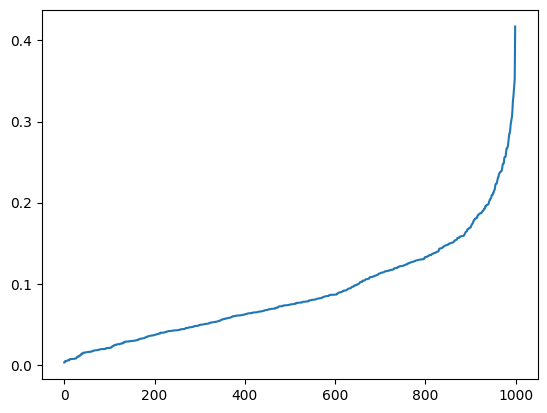

In [14]:
def plot_neighbour_distance(umap_embeddings):
    neigh = NearestNeighbors(n_neighbors=4)
    nbrs = neigh.fit(umap_embeddings)
    distances, indices = nbrs.kneighbors(umap_embeddings)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)

plot_neighbour_distance(umap_embeddings)

As we have 2dimensional data (Vectors) we will set the minimum cluster size fixed to 4 as it is mentioned in the Presentation paper of DBSCAN: 

"DBSCAN needs two parameters, Eps and MinPts. However, our experiments indicate that the k-dist graphs for k > 4
do not significantly differ from the 4-dist graph and, furthermore, they need considerably more computation. Therefore,
we eliminate the parameter MinPts by setting it to 4 for all
databases (for 2-dimensional data)."

The optimal value for epsilon will be found at the point of maximum curvature. This means arround 0.4

Let's create the clusters! We will use DB scan as we don't know the number of clusters found in the data

In [15]:
db = DBSCAN(eps=0.175, metric = 'euclidean', min_samples=4).fit(umap_embeddings)
labels = db.labels_

In [16]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [17]:
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 64
Estimated number of noise points: 280


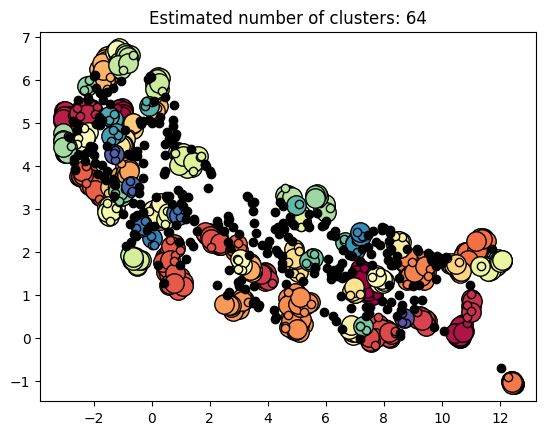

In [18]:
def plot_clusters(labels, n_clusters_, db):
    unique_labels = set(labels)
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = umap_embeddings[class_member_mask & core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )

        xy = umap_embeddings[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )

    plt.title(f"Estimated number of clusters: {n_clusters_}")
    plt.show()
    
plot_clusters(labels, n_clusters_, db)

In [19]:
labels

array([-1,  0, -1,  4, -1,  1,  2, -1,  1, -1, -1, -1, 22, -1, -1,  3,  4,
        3,  5, 57, -1,  6, -1, -1,  5, 39,  7,  8,  9, 10, 11, -1, 14, -1,
       51, -1, 12, 10, 13, 10, 13, 11, 36, 14, -1,  8, -1,  2, 11, 10, -1,
       15, 16,  0,  7,  5, 16, -1, 16, 17, 18, 14, -1, 19, 20, 13, -1, 11,
       15, 13, -1, 21, 31,  0, 63,  4, 10, -1, -1, 22, -1, 23, 17, 24, -1,
       25, 49, 16,  6, -1, -1, 20, -1, -1,  9, 13, -1, -1, 26, -1, 50, 56,
       -1, -1, 16, 27, 28, -1,  8, -1, -1,  6, 15,  0, 29, 18, 30,  9, 26,
       -1, 55, -1, 16, 19, -1, -1, -1, 10, -1, 20, 45, 10, 26, -1, -1, -1,
       36, 48, 10,  6, 31, 27, 32,  1, 27, -1, 15,  4, 26, 14, 29, -1, -1,
       27, 33, 19,  0, 34, -1,  3, 35, 13, 41,  9, 56,  0, 21, 36, 20, 25,
       18,  0, -1, 16, 50,  8, -1, 15, -1, 47, 37, 32, -1, 38, 61, -1, 13,
       16, -1, 26, -1, 39, 40, -1, 17,  7, 10, 38, 13, 10, 39, -1, 11, 20,
       -1, -1, 40, 29, -1, 15, 41, -1,  6, 16, 24, -1, -1, 37, -1, 10, -1,
       -1, 53, 41, -1, 10

In [20]:
df['cluster'] = labels
df

,text,emb,cluster
0,@Gerashchenko_en Damned if you do damned if yo...,"[[-0.6921208500862122, -0.2536858916282654, 0....",-1
1,@JonErlichman True,"[[-0.7792775630950928, -0.3437073826789856, 0....",0
2,@TaraBull808 Yeah it’s bizarre!,"[[-0.7318082451820374, -0.16536948084831238, 0...",-1
3,Another batch of Starlinks in orbit. These wil...,"[[-0.7834610342979431, -0.4638417363166809, -0...",4
4,@stillgray @Lukewearechange They are behind th...,"[[-0.8011219501495361, -0.28334784507751465, 0...",-1
...,...,...,...
995,Twitter will start incorporating mute &amp; bl...,"[[-0.8406918048858643, -0.4140477478504181, -0...",11
996,The people have spoken. Accounts who doxxed my...,"[[-0.8792438507080078, -0.46077966690063477, -...",48
997,@catturd2 Indeed there is no other reason,"[[-0.5551023483276367, -0.10706595331430435, 0...",13
998,@Lukewearechange Umm … yeah,"[[-0.7524970173835754, -0.221048042178154, 0.4...",2


In [21]:
list(df[df['cluster'] == 2]['text'])

['@Lukewearechange Accurate',
 'Ω',
 '@Lukewearechange Ahem …',
 '@TheBabylonBee 🤣💯',
 '@TheBabylonBee 🤣🤣',
 '@TheBabylonBee 🤣',
 '@TheBabylonBee 🤣',
 '@TheBabylonBee 🤣🤣',
 '@libsoftiktok 🧐',
 '@AOC 👋',
 '@alifarhat79 🤷\u200d♂️',
 'If you don’t think there’s at least a tiny chance you’re an NPC … you’re an NPC',
 '@universal_sci Carbs rock',
 '@TheBabylonBee 🤣🤣',
 '@TheBabylonBee 🤣',
 '@alifarhat79 🤣',
 '@TheQuartering 🤣',
 '@TheBabylonBee 🤣🤣',
 '@ClayTravis @Twitter Strange priorities …',
 '@Lukewearechange Umm … yeah']

## Let's try with a more specific Bert Model: BerTweet

In [22]:
bertweet = AutoModel.from_pretrained("vinai/bertweet-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [23]:
tensors = [torch.tensor([tokenizer.encode(tweet)]) for tweet in documents_text]
features = []
with torch.no_grad():
    for tensor in tensors:
        features.append(bertweet(tensor).pooler_output.tolist())
features = list(map(lambda x: x[0], features))

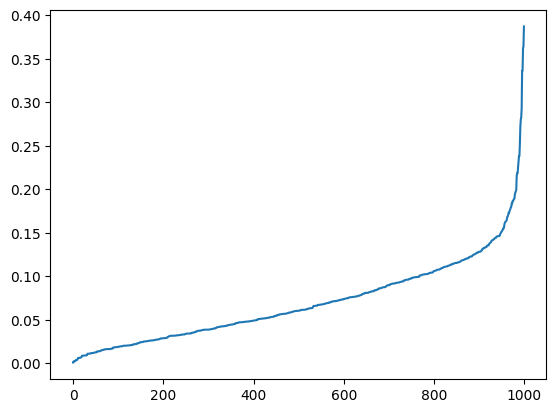

In [24]:
umap_embeddings = umap.UMAP(metric='cosine').fit_transform(features)
plot_neighbour_distance(umap_embeddings)

In [25]:
db = DBSCAN(eps=0.15, metric = 'euclidean', min_samples=10).fit(umap_embeddings)
labels = db.labels_

In [26]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 13
Estimated number of noise points: 776


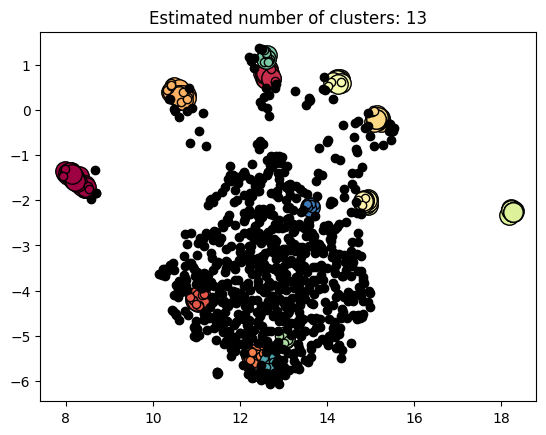

In [27]:
plot_clusters(labels, n_clusters_, db)

In [28]:
df2 = deepcopy(df)
df2['cluster'] = labels
df2

,text,emb,cluster
0,@Gerashchenko_en Damned if you do damned if yo...,"[[-0.6921208500862122, -0.2536858916282654, 0....",-1
1,@JonErlichman True,"[[-0.7792775630950928, -0.3437073826789856, 0....",-1
2,@TaraBull808 Yeah it’s bizarre!,"[[-0.7318082451820374, -0.16536948084831238, 0...",-1
3,Another batch of Starlinks in orbit. These wil...,"[[-0.7834610342979431, -0.4638417363166809, -0...",-1
4,@stillgray @Lukewearechange They are behind th...,"[[-0.8011219501495361, -0.28334784507751465, 0...",-1
...,...,...,...
995,Twitter will start incorporating mute &amp; bl...,"[[-0.8406918048858643, -0.4140477478504181, -0...",-1
996,The people have spoken. Accounts who doxxed my...,"[[-0.8792438507080078, -0.46077966690063477, -...",11
997,@catturd2 Indeed there is no other reason,"[[-0.5551023483276367, -0.10706595331430435, 0...",-1
998,@Lukewearechange Umm … yeah,"[[-0.7524970173835754, -0.221048042178154, 0.4...",7


In [29]:
list(df2[df2['cluster'] == 5]['text'])

['@TheBabylonBee Only a matter of time!',
 '@TheRightMelissa Back then George Washington was the “old guy” at age 44!',
 '@TheBabylonBee 🤣💯',
 '@banthebbc BBC is at least honest that they are the *British* Broadcasting Corporation unlike many others …',
 '@TheBabylonBee 🤣🤣',
 '@TheBabylonBee 🤣',
 '@TheBabylonBee 🤣',
 '@HowThingsWork_ The Drone Wars are already a big deal but we ain’t seen nothing yet …',
 '@TheBabylonBee 🤣🤣',
 '@TheOnion Been there',
 '@TheBabylonBee 🤣🤣',
 '@TheBabylonBee 🤣',
 '@esthercrawford I couldn’t agree more!',
 '@MrBeast Couldn’t agree more!',
 '@TheSonOfWalkley @Twitter Yup',
 '@TheBabylonBee 🤣🤣']

## Goood, I think it works way better!!

We would like to have real labels instead of numbers for each of the topics that have been classified. For doing so, I though on diferent possible euristics: 

- TF-IDF: to get out the most relevant words for each of the topics.
- Keyword Extraction: Keyword extraction tool such as Yake!

Let's try Yake.

In [30]:
list(df2[df2['cluster'] == 1]['text'])

['@TitterTakeover 🔥🔥',
 '@BillyM2k @Jason 😂💯',
 '@BillyM2k 🤣🤣',
 '@EvaFoxU 🤣🤣',
 '@BillyM2k @APStylebook 💯🤣',
 '@BLKMDL3 Same Mexico rocks! 🇲🇽',
 '@BillyM2k 🤣🤣',
 '@BillyM2k 🥳🥳',
 '@appuntito160 🤣🤣 he blocked me',
 '@weirdterrifying Ancient Egypt was 🔥🔥',
 '@gunsnrosesgirl3 “You’re not an NPC”',
 '@omzStudio @BillyM2k @mishaboar @StonksReddit 🤣🤣',
 '@DanielleFong Free jewelry woohoo 🤣🤣',
 '@Jason @nytimes @SBF_FTX 🤣🤣',
 '“Don’t be the clown on the clown car!” Too late haha',
 '@BillyM2k 🤣💯',
 '@barrel_bourbon Even the bots agree 🤣🤣',
 '@MilMileBattery @Steam @TheWitcherMS @Tesla 🔥🔥',
 '@FearTheFloof @neontaster 🤣💯',
 '@paulg 🤣🤣',
 '@johnrich I don’t have a home']

In [31]:
def yake_kw_extraction(df):
    topics = []
    kw = []
    clusters = list(df["cluster"].unique())
    for cluster in clusters:
        topics.append((cluster, " ".join(list(df[df['cluster'] == cluster]['text']))))
    kw_extractor = yake.KeywordExtractor(n=1, top=5)
    for cluster, topic in topics:
        kw.append((cluster,list(map(lambda x: x[0], sorted(kw_extractor.extract_keywords(topic), reverse=True, key=lambda y: y[1])))))
    return kw

yake_kw_extraction(df2)

[(-1, ['Good', 'Tesla', 'people', 'n’t', 'twitter']),
 (0, ['World', 'Starship', 'Tesla', 'Giga', 'Nevada']),
 (1, ['TitterTakeover', 'EvaFoxU', 'APStylebook', 'Mexico', 'Jason']),
 (2, ['Norris', 'Chuck', 'FTX', 'Falconwingsnj', 'MuskUniversity']),
 (3, ['Aquatic', 'Austen', 'SJM', 'Nice', 'stillgray']),
 (4, ['robbystarbuck', 'Kangaroos', 'Good', 'Yikes', 'TrungTPhan']),
 (9, ['True', 'Halloween', 'Romania', 'uscounteraction', 'AOC']),
 (12, ['debt', 'APompliano', 'Macron', 'Medicare', 'WallStreetSilv']),
 (11, ['Jason', 'misleading', 'Shame', 'public', 'MSNBC']),
 (5, ['agree', 'matter', 'time', 'n’t', 'TheBabylonBee']),
 (6, ['CEO', 'Lmaooo', 'Cool', 'February', 'WholeMarsBlog']),
 (10, ['TrungTPhan', 'pmarca', 'GadSaad', 'TAS', 'Optimus']),
 (7, ['alx', 'inaccurate', 'Sam', 'Sigh', 'Subtle']),
 (8, ['Twitter', 'megynkelly', 'judge', 'True', 'ggreenwald'])]

Let's try this with TF-IDF

In [32]:
def tf_idf(df):
    topics = []
    kw = []
    clusters = list(df["cluster"].unique())
    for cluster in clusters:
        topics.append((cluster, list(filter(lambda x : x!= "" , df[df['cluster'] == cluster]['text']))))
    vectorizer = TfidfVectorizer(stop_words="english")
    for cluster, topic in topics:
        try:
            X = vectorizer.fit_transform(topic)
            feature_array = np.array(vectorizer.get_feature_names_out())
            tfidf_sorting = np.argsort(X.toarray()).flatten()[::-1]
            top_n = feature_array[tfidf_sorting][:5]
            kw.append((cluster,top_n.tolist()))
        except Exception:
            kw.append((cluster, []))
    return kw

tf_idf(df2)

[(-1, ['bizarre', 'billfoxla', 'firewalls', 'fixes', 'fixed']),
 (0, ['94i61omyfs', 'https', 'zxedtl7lfm', 'fully', 'fqwmkum8yb']),
 (1, ['johnrich', 'home', 'don', 'woohoo', 'clown']),
 (2, ['billym2k', 'words', 'funds', 'alx', 'birds']),
 (3, ['true', 'stillgray', 'yikes', 'dreams', 'iamtheimmortal']),
 (4, ['hallelujah', 'yikes', 'welt', 'hear', 'great']),
 (9, ['worked', 'mattwallace888', 'lol', 'charm', 'like']),
 (12, ['interesting', 'wallstreetsilv', 'liking', 'lifespans', 'just']),
 (11, ['spoken', 'suspension', 'location', 'people', 'doxxed']),
 (5, ['thebabylonbee', 'yup', 'george', 'age', 'agree']),
 (6, ['ceo', 'finding', 'question', 'alive', 'twitter']),
 (10, ['wholemarsblog', 've', 'basedbeffjezos', 'billym2k', 'coincidence']),
 (7, ['yeah', 'umm', 'lukewearechange', 'good', 'maybe']),
 (8, ['true', 'ggreenwald', 'twitter', 'concerning', 'corpo'])]

## BEAUTIFULL!

Let's try to clean the text before extracting the keywords: 

- Delete @
- Delete links 

In [33]:
import re

def clean_tweet(tweet):
    tweet = re.sub(r'@\w*', '', tweet).lower()
    tweet = demoji.replace(tweet, "")
    return re.sub(r'https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b(?:[-a-zA-Z0-9()@:%_\+.~#?&\/=]*)', '', tweet)


In [34]:
df3 = deepcopy(df2)
df3["text"] = df3["text"].map(lambda x : clean_tweet(x))
df3

,text,emb,cluster
0,damned if you do damned if you don’t,"[[-0.6921208500862122, -0.2536858916282654, 0....",-1
1,true,"[[-0.7792775630950928, -0.3437073826789856, 0....",-1
2,yeah it’s bizarre!,"[[-0.7318082451820374, -0.16536948084831238, 0...",-1
3,another batch of starlinks in orbit. these wil...,"[[-0.7834610342979431, -0.4638417363166809, -0...",-1
4,they are behind the times,"[[-0.8011219501495361, -0.28334784507751465, 0...",-1
...,...,...,...
995,twitter will start incorporating mute &amp; bl...,"[[-0.8406918048858643, -0.4140477478504181, -0...",-1
996,the people have spoken. accounts who doxxed my...,"[[-0.8792438507080078, -0.46077966690063477, -...",11
997,indeed there is no other reason,"[[-0.5551023483276367, -0.10706595331430435, 0...",-1
998,umm … yeah,"[[-0.7524970173835754, -0.221048042178154, 0.4...",7


In [35]:
tf_idf(df3)

[(-1, ['bizarre', 'zerohedge', 'factory', 'fake', 'falcon']),
 (0, ['follow', 'world', 'cup', 'twitter', 'goal']),
 (1, ['home', 'don', 'woohoo', 'egypt', 'ancient']),
 (2, ['words', 'funds', 'birds', 'chuck', 'days']),
 (3, ['true', 'yikes', 'matter', 'apologize', 'aquatic']),
 (4, ['hallelujah', 'yikes', 'idea', 'congratulations', 'corrections']),
 (9, ['worked', 'charm', 'lol', 'like', 'knowledge']),
 (12, ['interesting', 'workers', 'macron', 'lifespans', 'just']),
 (11, ['location', 'doxxed', 'accounts', 'people', 'suspension']),
 (5, ['yup', 'deal', 'age', 'agree', 'ain']),
 (6, ['question', 'ceo', 'finding', 'alive', 'twitter']),
 (10, ['ve', 'thanks', 'tas', 'ri', 'philosophically']),
 (7, ['yeah', 'umm', 'inaccurate', 'old', 'minute']),
 (8, ['true', 'twitter', 'treatment', 'tragic', 'special'])]

In [36]:
yake_kw_extraction(df3)

[(-1, ['tweet', 'tweets', 'people', 'n’t', 'twitter']),
 (0, ['world', 'finished', 'tesla', 'factory', 'starship']),
 (1, ['npc', 'n’t', 'clown', 'mexico', 'rocks']),
 (2, ['norris', 'wise', 'words', 'chuck', 'friends']),
 (3, ['nonetheless', 'working', 'sjm', 'true', 'nice']),
 (4, ['kangaroos', 'good', 'idea', 'hear', 'yikes']),
 (9, ['awesome', 'true', 'lol', 'long', 'play']),
 (12, ['quarter', 'taxes', 'medicare', 'govt', 'thing']),
 (11, ['successful', 'year', 'misleading', 'shame', 'public']),
 (5, ['british', 'matter', 'agree', 'n’t', 'time']),
 (6, ['day', 'good', 'idea', 'lmaooo', 'february']),
 (10, ['philosophically', 'ipso', 'tas', 'facto', 'coincidence']),
 (7, ['inaccurate', 'sigh', 'kidding', 'subtle', 'matter']),
 (8, ['extremely', 'post', 'precisely', 'judge', 'true'])]

I think this is way better!

## Fine Tunning

Let's work a bit on the hyperparameters. It would be usefull to find the epsilon value automatically for the final alorithm to tune the clustering algoritm a bit more. Also, it has been thought that it would be nice setting min_pts to 2 as we want to consider all possible topics and sort them by relevancy.

Text(0, 0.5, 'Distance')

<Figure size 500x500 with 0 Axes>

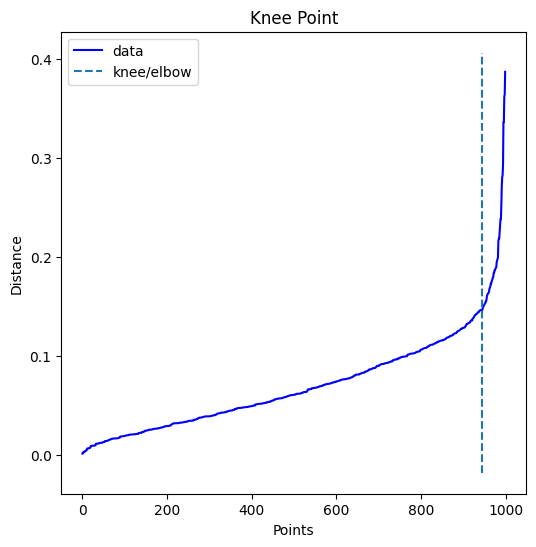

In [37]:
def calc_neghbour_distances(embedings, size):
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(umap_embeddings)
    distances, indices = nbrs.kneighbors(umap_embeddings)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    return distances

size = len(df3["text"])
distances = calc_neghbour_distances(umap_embeddings, size)
knee = KneeLocator(range(0,len(distances)), distances, S=1, curve='convex', direction='increasing')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

In [38]:
epsilon = distances[knee.knee]
epsilon

0.14637456671052138

In [39]:
db = DBSCAN(eps=epsilon, metric = 'euclidean', min_samples=2).fit(umap_embeddings)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

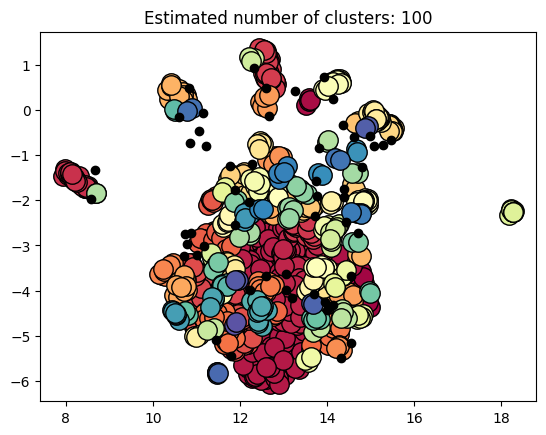

In [40]:
plot_clusters(labels, n_clusters_, db)

Now lets get the number of tweets per cluster and get the top 10 bigger topics

In [41]:
df4 = deepcopy(df3)
df4['cluster'] = labels
df4

,text,emb,cluster
0,damned if you do damned if you don’t,"[[-0.6921208500862122, -0.2536858916282654, 0....",-1
1,true,"[[-0.7792775630950928, -0.3437073826789856, 0....",0
2,yeah it’s bizarre!,"[[-0.7318082451820374, -0.16536948084831238, 0...",-1
3,another batch of starlinks in orbit. these wil...,"[[-0.7834610342979431, -0.4638417363166809, -0...",1
4,they are behind the times,"[[-0.8011219501495361, -0.28334784507751465, 0...",2
...,...,...,...
995,twitter will start incorporating mute &amp; bl...,"[[-0.8406918048858643, -0.4140477478504181, -0...",28
996,the people have spoken. accounts who doxxed my...,"[[-0.8792438507080078, -0.46077966690063477, -...",4
997,indeed there is no other reason,"[[-0.5551023483276367, -0.10706595331430435, 0...",21
998,umm … yeah,"[[-0.7524970173835754, -0.221048042178154, 0.4...",52


In [42]:
df4["text"] = df4["text"].map(lambda x : clean_tweet(x))
df4

,text,emb,cluster
0,damned if you do damned if you don’t,"[[-0.6921208500862122, -0.2536858916282654, 0....",-1
1,true,"[[-0.7792775630950928, -0.3437073826789856, 0....",0
2,yeah it’s bizarre!,"[[-0.7318082451820374, -0.16536948084831238, 0...",-1
3,another batch of starlinks in orbit. these wil...,"[[-0.7834610342979431, -0.4638417363166809, -0...",1
4,they are behind the times,"[[-0.8011219501495361, -0.28334784507751465, 0...",2
...,...,...,...
995,twitter will start incorporating mute &amp; bl...,"[[-0.8406918048858643, -0.4140477478504181, -0...",28
996,the people have spoken. accounts who doxxed my...,"[[-0.8792438507080078, -0.46077966690063477, -...",4
997,indeed there is no other reason,"[[-0.5551023483276367, -0.10706595331430435, 0...",21
998,umm … yeah,"[[-0.7524970173835754, -0.221048042178154, 0.4...",52


In [43]:
yake_topics = yake_kw_extraction(df4)
yake_topics

[(-1, ['left', 'great', 'people', 'n’t', 'damned']),
 (0, ['true', 'agreed']),
 (1, ['tap', 'orbit', 'tweet', 'twitter', 'lists']),
 (2, ['times', 'accurate']),
 (3, ['hydro', 'working', '’re', 'twitter', 'time']),
 (4, ['election', 'elections', 'state', 'people', 'twitter']),
 (5, ['expendable', 'parody', 'reality', 'incorrect', 'half']),
 (6, ['question', 'great', 'thread', 'good', 'twitter']),
 (7, ['biggest', 'battery', 'cell', 'pack', 'electric']),
 (8, ['world', 'finished', 'tesla', 'factory', 'starship']),
 (9, ['people', 'meeting', 'good', 'dsa', 'n’t']),
 (10, ['left', 'n’t', 'clown', 'mexico', 'rocks']),
 (11, ['eyes', 'hurt', 'minute', 'makes', 'operating']),
 (12, ['afterlife', 'chuck', 'emoji', 'major', 'friends']),
 (13, ['hell', 'lol', 'care', 'turns', 'left']),
 (14, ['true', 'strange', 'support', 'current', 'america']),
 (15, ['dedication', 'pretty', 'wow', 'yikes', 'extreme']),
 (16, ['people', 'idea', 'profound', 'kind', 'strong']),
 (17, ['wrong', 'doubly', 'switzer

In [44]:
tf_idf_topics = tf_idf(df4)
tf_idf_topics

[(-1, ['rental', 'years', 'faster', 'goal', 'glass']),
 (0, ['agreed', 'true', 'true', 'agreed']),
 (1, ['search', 'topics', 'couldn', 'sideways', 'does']),
 (2, ['times', 'accurate', 'times', 'accurate', 'accurate']),
 (3, ['primary', 'policy', 'essentially', 'rule', 'spam']),
 (4, ['lifted', 'doxxed', 'location', 'accounts', 'suspension']),
 (5, ['tangled', 'web', 'writing', 'favor', 'future']),
 (6, ['country', 'happened', 'interesting', 'forward', 'feb']),
 (7, ['true', 'pack', 'motor', 'factory', 'electric']),
 (8, ['follow', 'world', 'cup', 'twitter', 'goal']),
 (9, ['job', 'wants', 'successor', 'alive', 'twitter']),
 (10, ['home', 'don', 'halftime', 'game', 'free']),
 (11, ['yes', 'earn', 'immediate', 'hurt', 'hidden']),
 (12, ['hope', 'goes', 'yeah', 'joy', 'hard']),
 (13, ['messed', 'violent', 'location', 'aware', 'care']),
 (14, ['exactly', 'yeah', 'coming', 'including', 'gt']),
 (15, ['sharing', 'relentless', 'occasional', 'links', 'free']),
 (16, ['correct', 'words', 'unpre

# Let's get the biggest topics now

In [45]:
top_10_id = list(df4["cluster"].value_counts(sort=True)[:10].index)
top_10_id

/var/folders/c5/w6qgwv4j6vbfsds2gklg5q240000gn/T/ipykernel_63889/1511091965.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_10_id = list(df4["cluster"].value_counts(sort=True)[:10].index)


[4, 6, 5, -1, 8, 10, 31, 12, 14, 21]

In [46]:
top_10_count = list(df4["cluster"].value_counts(sort=True)[:10])
top_10_count

/var/folders/c5/w6qgwv4j6vbfsds2gklg5q240000gn/T/ipykernel_63889/2616636688.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_10_count = list(df4["cluster"].value_counts(sort=True)[:10])


[105, 85, 60, 54, 40, 37, 32, 31, 27, 25]

In [47]:
top_10_values = dict(zip(top_10_id, top_10_count))
top_10_values

{4: 105, 6: 85, 5: 60, -1: 54, 8: 40, 10: 37, 31: 32, 12: 31, 14: 27, 21: 25}

In [48]:
final_yake_topics = list(filter(lambda x : x[0] in top_10_id, yake_topics))
final_yake_topics

[(-1, ['left', 'great', 'people', 'n’t', 'damned']),
 (4, ['election', 'elections', 'state', 'people', 'twitter']),
 (5, ['expendable', 'parody', 'reality', 'incorrect', 'half']),
 (6, ['question', 'great', 'thread', 'good', 'twitter']),
 (8, ['world', 'finished', 'tesla', 'factory', 'starship']),
 (10, ['left', 'n’t', 'clown', 'mexico', 'rocks']),
 (12, ['afterlife', 'chuck', 'emoji', 'major', 'friends']),
 (14, ['true', 'strange', 'support', 'current', 'america']),
 (21, ['absolutely', 'population', 'bomb', 'book', 'scam']),
 (31, ['kangaroos', 'good', 'idea', 'hear', 'yikes'])]

In [49]:
final_tf_idf_topics = list(filter(lambda x : x[0] in top_10_id, tf_idf_topics))
final_tf_idf_topics

[(-1, ['rental', 'years', 'faster', 'goal', 'glass']),
 (4, ['lifted', 'doxxed', 'location', 'accounts', 'suspension']),
 (5, ['tangled', 'web', 'writing', 'favor', 'future']),
 (6, ['country', 'happened', 'interesting', 'forward', 'feb']),
 (8, ['follow', 'world', 'cup', 'twitter', 'goal']),
 (10, ['home', 'don', 'halftime', 'game', 'free']),
 (12, ['hope', 'goes', 'yeah', 'joy', 'hard']),
 (14, ['exactly', 'yeah', 'coming', 'including', 'gt']),
 (21, ['reason', 'yes', 'deamplify', 'mr', 'means']),
 (31, ['hallelujah', 'yikes', 'idea', 'congratulations', 'corrections'])]